In [1]:
import pandas as pd
from pyspi.calculator import Calculator
import numpy as np
from copy import deepcopy
import glob
import os
import random
import neuromaps
from neuromaps.parcellate import Parcellater
from nibabel import freesurfer as fs
import nibabel as nib
from neuromaps.datasets import fetch_annotation
from pathlib import Path
from scipy.spatial.distance import cdist
from scipy.stats import spearmanr, friedmanchisquare
import statsmodels.stats.multitest
from surfplot import Plot
from surfplot.datasets import load_example_data
from neuromaps.datasets import fetch_fslr

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

objc[66565]: Class QT_ROOT_LEVEL_POOL__THESE_OBJECTS_WILL_BE_RELEASED_WHEN_QAPP_GOES_OUT_OF_SCOPE is implemented in both /Users/abry4213/miniforge3/envs/annie_env/lib/libQt6Core.6.8.2.dylib (0x3022e16b8) and /Users/abry4213/miniforge3/envs/annie_env/lib/libQt5Core.5.15.15.dylib (0x3182852f8). One of the two will be used. Which one is undefined.
objc[66565]: Class KeyValueObserver is implemented in both /Users/abry4213/miniforge3/envs/annie_env/lib/libQt6Core.6.8.2.dylib (0x3022e16e0) and /Users/abry4213/miniforge3/envs/annie_env/lib/libQt5Core.5.15.15.dylib (0x318285320). One of the two will be used. Which one is undefined.
objc[66565]: Class RunLoopModeTracker is implemented in both /Users/abry4213/miniforge3/envs/annie_env/lib/libQt6Core.6.8.2.dylib (0x3022e1780) and /Users/abry4213/miniforge3/envs/annie_env/lib/libQt5Core.5.15.15.dylib (0x318285370). One of the two will be used. Which one is undefined.


In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

# Load in the data and filter to directed information (DI) with a Gaussian estimator

In [10]:
data_path = "/Users/abry4213/data/HCP100/"

# Load in pyspi SPI info 
pyspi_info = pd.read_csv("../feature_extraction/pyspi/pyspi_SPI_info.csv")

# Load hierarchy-based DK maps
hierarchy_dk_neuromaps_res = pd.read_csv('hierarchy_dk_neuromaps_res.csv')
AHBA_PC1_based_hierarchy_order = hierarchy_dk_neuromaps_res.query("Description=='PC1 of Allen Human Brain Atlas'").sort_values('Value').drop_duplicates(subset=['Base_Region']).Base_Region.tolist()

# Load in all the pyspi homotopic res
all_DI_gaussian_res = (pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*DI_Gaussian*.csv")])
                     .query("SPI=='di_gaussian'")
                     .dropna(subset=['value'])
                     .reset_index(drop=True)
                     .drop(columns=['index'])
                     .drop_duplicates()
                     .assign(Connectivity_Type = lambda x: np.where(x.hemi_from==x.hemi_to, "Intra-hemispheric", "Inter-hemispheric"))
                     )

all_pearson_res = (pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*DI_Gaussian*.csv")])
                     .query("SPI=='cov_EmpiricalCovariance'")
                     .dropna(subset=['value'])
                     .reset_index(drop=True)
                     .drop(columns=['index'])
                     .drop_duplicates()
                     .assign(Connectivity_Type = lambda x: np.where(x.hemi_from==x.hemi_to, "Intra-hemispheric", "Inter-hemispheric"))
                     )

# Look at how much HoFC compares to intra-hemispheric and heterotopic connections

In [4]:
all_pearson_res_with_HoFC = (all_pearson_res
 .drop(columns=['Connectivity_Type'])
 .assign(Connection_Type = lambda x: np.where(x.base_region_from == x.base_region_to, 'Homotopic', np.where(x.hemi_from==x.hemi_to, 'Intra-hemispheric', 'Inter-hemispheric')),
         value_abs = lambda x: np.abs(x.value))
 .groupby(['base_region_from', 'base_region_to', 'Connection_Type'])['value_abs']
    .mean()
    .reset_index()
    .rename(columns={'value_abs': 'Mean_Abs_Pearson_R'})
)
all_pearson_res_with_HoFC.head()

,base_region_from,base_region_to,Connection_Type,Mean_Abs_Pearson_R
0,bankssts,bankssts,Homotopic,0.398518
1,bankssts,caudalanteriorcingulate,Inter-hemispheric,0.100519
2,bankssts,caudalanteriorcingulate,Intra-hemispheric,0.103446
3,bankssts,caudalmiddlefrontal,Inter-hemispheric,0.132292
4,bankssts,caudalmiddlefrontal,Intra-hemispheric,0.146388


In [39]:
all_pearson_res_with_HoFC.head()

,base_region_from,base_region_to,Connection_Type,Mean_Abs_Pearson_R
0,bankssts,bankssts,Homotopic,0.398518
1,bankssts,caudalanteriorcingulate,Inter-hemispheric,0.100519
2,bankssts,caudalanteriorcingulate,Intra-hemispheric,0.103446
3,bankssts,caudalmiddlefrontal,Inter-hemispheric,0.132292
4,bankssts,caudalmiddlefrontal,Intra-hemispheric,0.146388


In [46]:
# Group by base_region_from and compute the percentile of Mean_Abs_Pearson_R across all base_region_to
connectivity_percentiles = all_pearson_res_with_HoFC.groupby('base_region_from')['Mean_Abs_Pearson_R'].rank(pct=True).reset_index().rename(columns={'Mean_Abs_Pearson_R': 'Percentile'}).Percentile
all_pearson_res_with_HoFC['Percentile'] = connectivity_percentiles

all_pearson_res_with_HoFC.query("Connection_Type=='Homotopic'").sort_values('Percentile', ascending=False).head()

,base_region_from,base_region_to,Connection_Type,Mean_Abs_Pearson_R,Percentile
1173,parahippocampal,parahippocampal,Homotopic,0.153858,1.0
966,medialorbitofrontal,medialorbitofrontal,Homotopic,0.326307,1.0
2139,supramarginal,supramarginal,Homotopic,0.552356,1.0
2070,superiortemporal,superiortemporal,Homotopic,0.546761,1.0
2001,superiorparietal,superiorparietal,Homotopic,0.771155,1.0


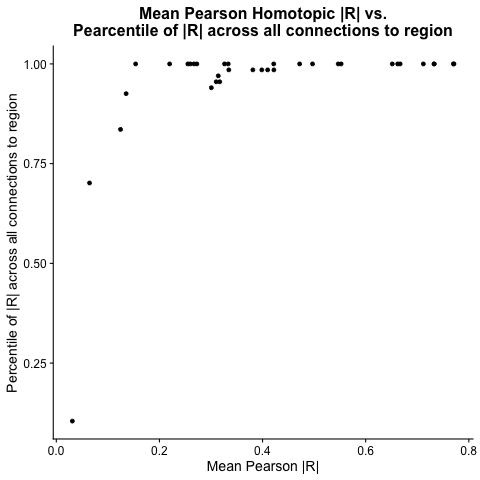

In [50]:
%%R -i all_pearson_res_with_HoFC

all_pearson_res_with_HoFC %>%
    filter(Connection_Type=='Homotopic') %>% 
    ggplot(data=., mapping=aes(x=Mean_Abs_Pearson_R, y=Percentile)) +
    ggtitle("Mean Pearson Homotopic |R| vs.\nPearcentile of |R| across all connections to region") +
    xlab("Mean Pearson |R|") +
    ylab("Percentile of |R| across all connections to region") +
    geom_point() +
    theme(plot.title = element_text(hjust = 0.5))

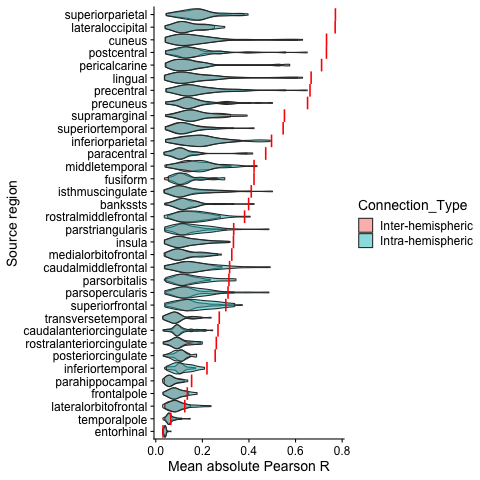

In [5]:
%%R -i all_pearson_res_with_HoFC

homotopic_subset = all_pearson_res_with_HoFC %>% filter(Connection_Type == "Homotopic") 

region_order <- homotopic_subset %>% arrange(desc(Mean_Abs_Pearson_R)) %>% pull(base_region_from)

homotopic_subset <- homotopic_subset %>% 
    mutate(base_region_from = factor(base_region_from, levels=region_order)) 

all_pearson_res_with_HoFC %>%
    select(base_region_from, Connection_Type, Mean_Abs_Pearson_R) %>% 
    mutate(base_region_from = factor(base_region_from, levels=region_order)) %>%
    filter(Connection_Type != "Homotopic") %>%
    ggplot(mapping=aes(x=base_region_from, y=Mean_Abs_Pearson_R)) +
    scale_x_discrete(limits=rev) +
    geom_violin(scale='width', aes(fill=Connection_Type), position='identity', alpha=0.5) +
    xlab("Source region") +
    ylab("Mean absolute Pearson R") +
    stat_summary(data=homotopic_subset, color="red", fun="mean", geom="crossbar", width=1, linewidth=0.3, 
          show.legend=FALSE)+
    coord_flip()

In [6]:
all_pearson_res_with_HoFC.head()

,base_region_from,base_region_to,Connection_Type,Mean_Abs_Pearson_R
0,bankssts,bankssts,Homotopic,0.398518
1,bankssts,caudalanteriorcingulate,Inter-hemispheric,0.100519
2,bankssts,caudalanteriorcingulate,Intra-hemispheric,0.103446
3,bankssts,caudalmiddlefrontal,Inter-hemispheric,0.132292
4,bankssts,caudalmiddlefrontal,Intra-hemispheric,0.146388


In [12]:
# Make a correlation matrix where the diagonal is values corresponding to Connection_Type=='Homotopic', 
# the lower triangle to Connection_Type=='Intra-hemispheric', and the upper triangle to Connection_Type=='Inter-hemispheric'

# Get unique regions
regions = sorted(set(all_pearson_res_with_HoFC["base_region_from"]).union(set(all_pearson_res_with_HoFC["base_region_to"])))

# Create empty square dataframe
pearson_corr_conn_matrix = pd.DataFrame(np.nan, index=regions, columns=regions)

# Fill matrix based on connection type
for _, row in all_pearson_res_with_HoFC.iterrows():
    src, tgt, conn_type, value = row["base_region_from"], row["base_region_to"], row["Connection_Type"], row["Mean_Abs_Pearson_R"]
    
    if src == tgt and conn_type == "Homotopic":
        pearson_corr_conn_matrix.loc[src, tgt] = value  # Diagonal
    elif src != tgt:
        # Sort to determine upper/lower placement
        region1, region2 = sorted([src, tgt])

        if conn_type == "Intra-hemispheric":
            pearson_corr_conn_matrix.loc[region2, region1] = value  # Lower triangle
        elif conn_type == "Inter-hemispheric":
            pearson_corr_conn_matrix.loc[region1, region2] = value  # Upper triangle

# Sort the rows and columns based on AHBA_PC1_based_hierarchy_order
pearson_corr_conn_matrix = pearson_corr_conn_matrix.loc[AHBA_PC1_based_hierarchy_order, AHBA_PC1_based_hierarchy_order]

In [38]:
%%R -i pearson_corr_conn_matrix,AHBA_PC1_based_hierarchy_order

pearson_corr_conn_matrix %>% 
    mutate(region_1 = rownames(.)) %>%
    pivot_longer(-region_1, names_to="region_2", values_to="Mean_Abs_Pearson_R") %>%
    mutate(region_1 = factor(region_1, levels=AHBA_PC1_based_hierarchy_order),
           region_2 = factor(region_2, levels=AHBA_PC1_based_hierarchy_order)) %>%
    ggplot(data=., mapping=aes(x=region_1, y=region_2, fill=Mean_Abs_Pearson_R)) +
    geom_tile() +
    scale_fill_viridis_c(option='inferno') +
    ylab("Inter-hemispheric") +
    xlab("Intra-hemispheric") +
    labs(fill="Mean Pearson |R|") +
    scale_x_discrete(limits=rev) +
#     scale_y_discrete(limits=rev) +
    guides(fill=guide_colorbar(title.position="top", title.hjust=0.5)) +
    theme(legend.position='bottom',
          legend.key.width=unit(2, "cm"),
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank())
ggsave("../plots/Pearson_mean_connectivity_type_abs_matrix.svg", width=6, height=5, units="in", dpi=300)

## Entorhinal as source for an example hierarchy plot

In [62]:
source_region = "entorhinal"
entorhinal_example_pearson = (all_pearson_res
    .query("base_region_from==@source_region")
    .assign(Connection_Type = lambda x: np.where(x.hemi_from==x.hemi_to, 'Intra-hemispheric', 'Inter-hemispheric'))
    .groupby(['Subject', 'SPI', 'base_region_to', 'Connection_Type'])['value']
    .mean()
    .reset_index()
    .groupby(['SPI', 'base_region_to', 'Connection_Type'])['value']
    .mean()
    .reset_index()
    .rename(columns={'value': 'Mean_Pearson_FC'})
)


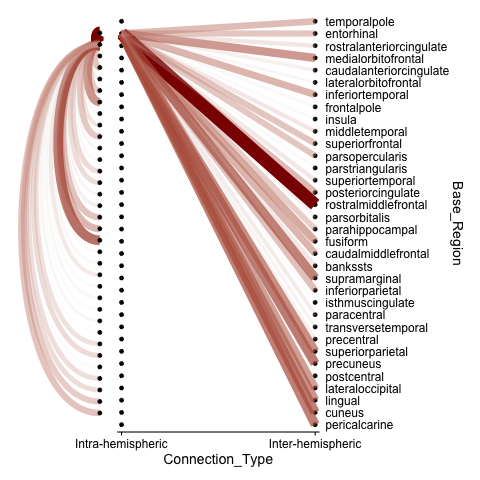

In [71]:
%%R -i entorhinal_example_pearson,AHBA_PC1_based_hierarchy_order

library(tidyverse)
library(ggraph)
library(tidygraph)
library(igraph)

inter_hemispheric_connection_lines <- entorhinal_example_pearson %>% 
  filter(Connection_Type == "Inter-hemispheric") %>%
  mutate(base_region_from = "entorhinal") %>% 
  mutate(Connection_ID = row_number()) %>% 
  pivot_longer(cols=c(base_region_from, base_region_to), names_to="names", values_to="Base_Region") %>%
  select(-names) %>%
  rename("Pearson_R" = "Mean_Pearson_FC") %>%
  mutate(Base_Region = factor(Base_Region, levels=AHBA_PC1_based_hierarchy_order),
         Pearson_R = abs(Pearson_R),
         Connection_Type = factor(Connection_Type, levels=c("Intra-hemispheric", "Inter-hemispheric"))) %>% 
  group_by(Connection_ID) %>% 
  mutate(Connection_Type = c("Intra-hemispheric", "Inter-hemispheric"))

points_data_to_plot <- data.frame(Base_Region=rep(AHBA_PC1_based_hierarchy_order, 2),
                                  Value = rep(0, 68),
                                  Connection_Type = c(rep("Intra-hemispheric", 34),
                                                      rep("Inter-hemispheric", 34))) %>%
  mutate(Base_Region = factor(Base_Region, levels=AHBA_PC1_based_hierarchy_order),
         Connection_Type = factor(Connection_Type, levels=c("Intra-hemispheric", "Inter-hemispheric")))

inter_plot <- ggplot(mapping=aes(x=Connection_Type, y=Base_Region)) +
  geom_point(data=points_data_to_plot, aes(x=Connection_Type, y=Base_Region)) +
  geom_line(data=inter_hemispheric_connection_lines, aes(x=Connection_Type, y=Base_Region, 
                                                         group=Connection_ID, 
                                                         alpha=Pearson_R, linewidth=Pearson_R,
                                                         color=Pearson_R))+
  scale_x_discrete(expand=c(0.01,0.01)) +
  scale_y_discrete(limits=rev, position = "right") +
  scale_color_gradient(low="gray90", high="darkred") +
  theme(legend.position='none',
        axis.line.y = element_blank(),
        axis.ticks.y = element_blank())

# define nodes
nodes <- data.frame(node_name = rev(AHBA_PC1_based_hierarchy_order)) %>%
  mutate(node_name = factor(node_name, levels = rev(AHBA_PC1_based_hierarchy_order)))

# define edges
edges <- entorhinal_example_pearson %>% 
  filter(Connection_Type == "Intra-hemispheric") %>%
  mutate(base_region_from = "entorhinal") %>% 
  mutate(Connection_ID = row_number()) %>% 
  rename("from" = "base_region_from",
         "to" = "base_region_to") %>% 
  mutate(Mean_Pearson_FC = abs(Mean_Pearson_FC)) %>%
  mutate(from = factor(from, levels=AHBA_PC1_based_hierarchy_order),
         to = factor(to, levels=AHBA_PC1_based_hierarchy_order)) %>%
  arrange(from, to)

# build network from nodes and edges
network <- tbl_graph(edges = edges, nodes = nodes, directed = FALSE)

# Extract layout and modify x/y coordinates
layout_data <- create_layout(network, layout = "linear")

# Swap x and y to align nodes along the y-axis
layout_data <- layout_data %>%
  mutate(temp = x, x = y, y = temp) %>%  # Swap x and y
  select(-temp)  # Remove temporary column

# Flip the x-axis only
layout_data$x <- -layout_data$x  
# Use the modified layout in ggraph
intra_plot <- ggraph(layout_data) +
  geom_edge_arc(aes(color = Mean_Pearson_FC,
                    width = Mean_Pearson_FC,
                    alpha = Mean_Pearson_FC)) +
  geom_node_point() +
  scale_edge_color_gradient(low="gray90", high="darkred") +
  theme(legend.position='none')

wrap_plots(list(intra_plot, inter_plot), widths=c(0.3, 0.7))

# ggsave("../plots/hierarchy_network_properties/entorhinal_connectivity_profile.svg", width=8, height=7, units="in", dpi=300)

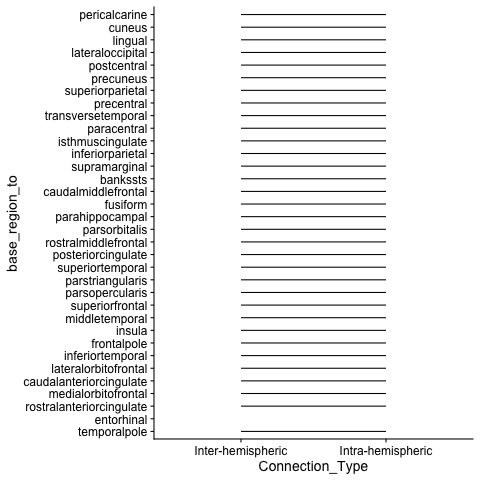

In [28]:
%%R -i entorhinal_example_DI_out,AHBA_PC1_based_hierarchy_order

entorhinal_example_DI_out %>% 
    mutate(base_region_to = factor(base_region_to, levels=AHBA_PC1_based_hierarchy_order)) %>%
    ggplot(mapping=aes(x=Connection_Type, y=base_region_to)) +
    geom_line(aes(group=base_region_to), color="black")

In [ ]:

# Filter to DI gaussian
di_gaussian_homotopic_res = all_homotopic_res.query("SPI=='di_gaussian'")

# Compute the mean value for each base_region_to in di_gaussian_homotopic_res
di_gaussian_homotopic_res_mean = (di_gaussian_homotopic_res
                                  .groupby(['Subject', 'base_region_to', 'SPI'])['value'].mean().reset_index()
                                  .groupby("base_region_to")['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"base_region_to": "Base_Region",
                                                   "value": "Mean_DI_Gaussian"}))

di_gaussian_homotopic_res_for_dk = (di_gaussian_homotopic_res
                                  .groupby(["base_region_to", 'hemi_from'])['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"value": "Mean_DI_Gaussian"})
                                    )

## Visualize the mean DI from L--R and R--L in the brain (averaged across hemispheres, first)

In [4]:
# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

# Read in the DK atlas
lh_labels, lh_ctab, lh_names = fs.read_annot(lh_dk)
rh_labels, rh_ctab, rh_names = fs.read_annot(rh_dk)

# Some big endian byte-swapping is needed
lh_labels = lh_labels.byteswap().view(lh_labels.dtype.newbyteorder('='))
rh_labels = rh_labels.byteswap().view(rh_labels.dtype.newbyteorder('='))

# Create a lookup table dataframe
lh_names_df = pd.DataFrame({'Region': lh_names, 'Vertex_Value': range(len(lh_names))}).assign(Region = lambda x: x['Region'].str.decode('utf-8'))
rh_names_df = pd.DataFrame({'Region': rh_names, 'Vertex_Value': range(len(rh_names))}).assign(Region = lambda x: x['Region'].str.decode('utf-8'))

# Convert vertices to a DataFrame
lh_labels_df = pd.DataFrame({'Vertex_Value': lh_labels, 'Vertex_Index': range(len(lh_labels))}).merge(lh_names_df, on='Vertex_Value', how='left')
rh_labels_df = pd.DataFrame({'Vertex_Value': rh_labels, 'Vertex_Index': range(len(rh_labels))}).merge(rh_names_df, on='Vertex_Value', how='left')

# Merge with DI Gaussian homotopic res
lh_labels_df_with_DI = lh_labels_df.merge(di_gaussian_homotopic_res_for_dk.query("hemi_from=='left'"), left_on='Region', right_on='base_region_to', how='left')
rh_labels_df_with_DI = rh_labels_df.merge(di_gaussian_homotopic_res_for_dk.query("hemi_from=='right'"), left_on='Region', right_on='base_region_to', how='left')

## What is the left-right asymmetry in Gaussian-DI values?

In [15]:
region_DI_subtract_diffs = (di_gaussian_homotopic_res
 .groupby(['Subject', 'base_region_to'])
    .apply(lambda x: x.value[x.hemi_from=='left'].values - x.value[x.hemi_from=='right'].values)
    .reset_index()
    .rename(columns={0: 'RL_minus_LR'})
    # Flatten the list of arrays
    .explode('RL_minus_LR')
    )
region_DI_subtract_diffs

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_26583/1156760007.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  region_DI_subtract_diffs = (di_gaussian_homotopic_res


,Subject,base_region_to,RL_minus_LR
0,100307,bankssts,0.00733
1,100307,caudalanteriorcingulate,-0.055134
2,100307,caudalmiddlefrontal,-0.145232
3,100307,cuneus,-0.032814
4,100307,entorhinal,-0.001521
...,...,...,...
3395,899885,superiorparietal,-0.166567
3396,899885,superiortemporal,-0.046332
3397,899885,supramarginal,-0.26148
3398,899885,temporalpole,-0.010385


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "RL_minus_LR". Fall back to string conversion. The error is: <class 'numpy.float64'>
  warnings.warn('Error while trying to convert '


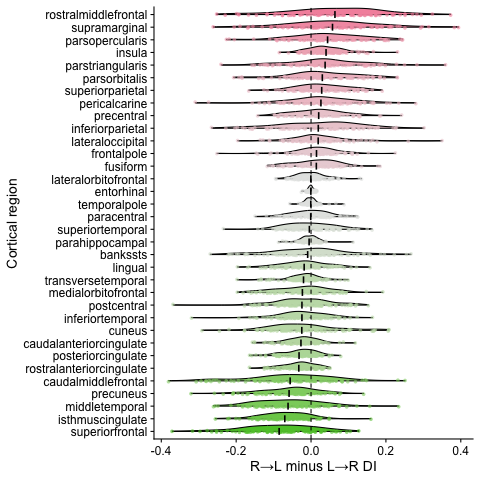

In [54]:
%%R -i region_DI_subtract_diffs -o region_order_DI_asym

# What is the difference in DI by brain region?
region_DI_subtract_diffs <- region_DI_subtract_diffs %>%
  mutate(RL_minus_LR = as.numeric(RL_minus_LR)) %>%
  group_by(base_region_to) %>%
  mutate(mean_RL_minus_LR = mean(RL_minus_LR, na.rm=TRUE),
         sd_RL_minus_LR = sd(RL_minus_LR, na.rm=TRUE)) %>%
  ungroup() %>%
  mutate(base_region_to = fct_reorder(base_region_to, mean_RL_minus_LR, .fun=median))

region_order_DI_asym <- region_DI_subtract_diffs %>% arrange(base_region_to) %>% distinct(base_region_to) %>% pull(base_region_to)

region_DI_subtract_diffs %>%
  ggplot(data=., mapping=aes(x=base_region_to, y=RL_minus_LR, fill=mean_RL_minus_LR)) +
  geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
  geom_point(aes(color = mean_RL_minus_LR), position = position_jitter(width = 0.075, height=0),
                          size = 1.75, alpha=0.6, stroke=0) +
  stat_summary(color="black", fun="mean", geom="crossbar", width=0.55, linewidth=0.3, 
          show.legend=FALSE, position = position_dodge(width=0))+
  scale_fill_gradient2(high="#f47599", low="#5dc636", mid="gray90") +
  scale_color_gradient2(high="#f47599", low="#5dc636", mid="gray90") +
  geom_hline(yintercept=0, linetype=2) +
  theme(legend.position="none")+
  coord_flip() +
  ylab("R\u2192L minus L\u2192R DI") +
  xlab("Cortical region")
# ggsave("../plots/left_right_asymmetry/DI_RL_minus_LR_violins.svg", width=6, height=8, dpi=300, units="in")

In [ ]:
region_DI_subtract_diffs_mean = (region_DI_subtract_diffs[['base_region_to', 'mean_RL_minus_LR']]
                                 .drop_duplicates()
                                 .rename(columns={"base_region_to": "Base_Region",
                                                  "mean_RL_minus_LR": "Mean_RL_minus_LR_DI"})
)
region_DI_subtract_diffs_mean.head()

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


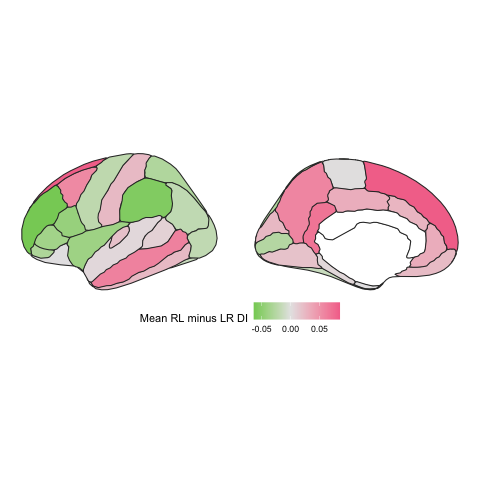

In [25]:
%%R -i region_DI_subtract_diffs_mean

# Plot in the brain
region_DI_subtract_diffs_mean %>%
  distinct(Base_Region, Mean_RL_minus_LR_DI) %>%
  mutate(label = glue("lh_{Base_Region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = Mean_RL_minus_LR_DI),
        position = "stacked", colour = "gray20", hemisphere="left") +
  theme_void() +
  scale_fill_gradient2(high="#f47599", low="#5dc636", mid="gray90", na.value = "white") +
  labs(fill = "Mean RL minus LR DI") +
  theme(plot.title = element_blank(),
        legend.position = "bottom")
# ggsave("../plots/left_right_asymmetry/DI_RL_minus_LR_brain.svg", width=4, height=3, dpi=300, units="in")

## Compare with left-right asymmetry in cortical hierarchy map indices

In [26]:

if not os.path.exists("hierarchy_dk_neuromaps_res.csv"):
    nm_atlas_df = pd.read_csv('hierarchy_neuromaps_atlases.csv')

    # Convert the DK atlas to gifti format
    dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
    dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

    # Fit a Parcellator object
    parc = Parcellater(dk_gifti, 'fsaverage', resampling_target='parcellation')

    # Loop through each atlas, extract the values in Desikan-Killiany space, and create a dataframe
    all_dk_neuromaps_res_list = []
    for i, row in nm_atlas_df.iterrows():
        this_row_category = row['Category']
        this_row_desc = row['Description']
        source, desc, space, den = row['Filename'].split('-')

        try:
            print(f"Fetching {source} {desc} {space} {den}")
            this_atlas_data = fetch_annotation(source=source, desc=desc, space=space, 
                                                den=den, data_dir=Path("/Users/abry4213/neuromaps-data"))
            
            # Extract this atlas' values in Desikan-Killiany space
            parc_iter = deepcopy(parc)
            this_atlas_data_in_dk = parc_iter.fit_transform(this_atlas_data, space)

            # Create a dataframe
            this_atlas_data_in_dk_df = pd.DataFrame({'Category': this_row_category,
                                                        'Description': this_row_desc,
                                                        'Region_Index': range(len(this_atlas_data_in_dk)),
                                                        'Value': this_atlas_data_in_dk}).merge(brain_region_info, on="Region_Index")
            
            # Append to the list
            all_dk_neuromaps_res_list.append(this_atlas_data_in_dk_df)
        
        except Exception as e:
            print(f"Error parcellating {source} {desc} {space} {den}: {e}")
            continue

    # Concatenate all the dataframes
    hierarchy_dk_neuromaps_res = pd.concat(all_dk_neuromaps_res_list)

    # Save the results
    hierarchy_dk_neuromaps_res.to_csv("hierarchy_dk_neuromaps_res.csv", index=False)

else:
    hierarchy_dk_neuromaps_res = pd.read_csv("hierarchy_dk_neuromaps_res.csv")

hierarchy_dk_neuromaps_res_hemi_avg = hierarchy_dk_neuromaps_res.groupby(['Category', 'Description', 'Base_Region'])['Value'].mean().reset_index()

### 1. Does L-R asymmetry correlate between DI and neuromaps hierarchy indices?

In [29]:
# Group by Description and Base_Region, and find the difference in Value when Hemisphere is left vs right
hierarchy_dk_neuromaps_res_hemi_diff = (hierarchy_dk_neuromaps_res
                                        .groupby(['Category', 'Description', 'Base_Region', 'Hemisphere'])['Value']
                                        .mean()
                                        .unstack()
                                        .assign(Diff = lambda x: x['Left'] - x['Right'])
                                        .reset_index()
                                        .drop(columns=['Left', 'Right'])
                                        .rename(columns={"Diff": "Mean_L_minus_R"}))
hierarchy_dk_neuromaps_res_hemi_diff

# Compute left-right asymmetry in the neuromaps hierarchy measures for comparison with DI L-R asymmetry
hierarchy_dk_neuromaps_res_hemi_diff_DI = hierarchy_dk_neuromaps_res_hemi_diff.merge(region_DI_subtract_diffs_mean, on='Base_Region', how='left')

# Group by 'Category' and 'Description' and compute the Spearman correlation
spearman_corrs_neuromaps_asym_and_DI_asym = (hierarchy_dk_neuromaps_res_hemi_diff_DI
                              .groupby(['Category', 'Description'])
                              .apply(lambda x: spearmanr(x['Mean_L_minus_R'], x['Mean_RL_minus_LR_DI'])).apply(pd.Series)
                              .reset_index()
                              .assign(SPI = 'di_gaussian'))

# Rename the columns for clarity
spearman_corrs_neuromaps_asym_and_DI_asym.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

# Display the results
spearman_corrs_neuromaps_asym_and_DI_asym['p_val_BH'] = statsmodels.stats.multitest.multipletests(spearman_corrs_neuromaps_asym_and_DI_asym.p_value, method="fdr_bh")[1]

# Filter to significant results
spearman_corrs_neuromaps_asym_and_DI_asym_sig = spearman_corrs_neuromaps_asym_and_DI_asym.query("p_val_BH < 0.05 & abs(Spearman_Correlation) > 0.5")

Hemisphere,Category,Description,Base_Region,Mean_L_minus_R
0,Anatomical hierarchy,T1w vs. T2w MRI signal,bankssts,-0.034473
1,Anatomical hierarchy,T1w vs. T2w MRI signal,caudalanteriorcingulate,-0.023402
2,Anatomical hierarchy,T1w vs. T2w MRI signal,caudalmiddlefrontal,0.006868
3,Anatomical hierarchy,T1w vs. T2w MRI signal,cuneus,0.015934
4,Anatomical hierarchy,T1w vs. T2w MRI signal,entorhinal,0.009476
...,...,...,...,...
97,Transcriptomic hierarchy,PC1 of Allen Human Brain Atlas,superiorparietal,0.052149
98,Transcriptomic hierarchy,PC1 of Allen Human Brain Atlas,superiortemporal,0.124994
99,Transcriptomic hierarchy,PC1 of Allen Human Brain Atlas,supramarginal,-0.087497
100,Transcriptomic hierarchy,PC1 of Allen Human Brain Atlas,temporalpole,-0.021793


### 2. Does L-R asymmetry in DI correlate with regions' hierarchy magnitudes? 

In [38]:
# Compute left-right asymmetry in the neuromaps hierarchy measures for comparison with DI L-R asymmetry
hierarchy_dk_neuromaps_res_with_DI_asym = hierarchy_dk_neuromaps_res_hemi_avg.merge(region_DI_subtract_diffs_mean, on='Base_Region', how='left')


# Group by 'Category' and 'Description' and compute the Spearman correlation
spearman_corrs_neuromaps_magnitude_and_DI_asym = (hierarchy_dk_neuromaps_res_with_DI_asym
                              .groupby(['Category', 'Description'])
                              .apply(lambda x: spearmanr(x['Value'], x['Mean_RL_minus_LR_DI'])).apply(pd.Series)
                              .reset_index()
                              .assign(SPI = 'di_gaussian'))

# Rename the columns for clarity
spearman_corrs_neuromaps_magnitude_and_DI_asym.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

# Display the results
spearman_corrs_neuromaps_magnitude_and_DI_asym['p_val_BH'] = statsmodels.stats.multitest.multipletests(spearman_corrs_neuromaps_magnitude_and_DI_asym.p_value, method="fdr_bh")[1]

# Filter to significant results
spearman_corrs_neuromaps_magnitude_and_DI_asym_sig = spearman_corrs_neuromaps_magnitude_and_DI_asym.query("p_val_BH < 0.05 & abs(Spearman_Correlation) > 0.5")

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_81581/2069073392.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_neuromaps_magnitude_and_DI_asym = (hierarchy_dk_neuromaps_res_with_DI_asym


### 3. Is the DI L/R asymmetry associated with L/R asymmetry in ANY neuromaps?

In [39]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../Brain_Region_Info.csv")

# Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

if not os.path.exists("all_dk_neuromaps_res.csv"):
    nm_atlas_df = pd.read_csv('neuromaps_atlases.csv')

    # Convert the DK atlas to gifti format
    dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
    dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

    # Fit a Parcellator object
    parc = Parcellater(dk_gifti, 'fsaverage', resampling_target='parcellation')

    # Loop through each atlas, extract the values in Desikan-Killiany space, and create a dataframe
    all_dk_neuromaps_res_list = []
    for i, row in nm_atlas_df.iterrows():
        this_row_category = row['Category']
        this_row_desc = row['Description']
        source, desc, space, den = row['Filename'].split('-')

        try:
            print(f"Computing correlations for {source} {desc} {space} {den}")
            this_atlas_data = fetch_annotation(source=source, desc=desc, space=space, 
                                                den=den, data_dir=Path("/Users/abry4213/neuromaps-data"))
            
            # Extract this atlas' values in Desikan-Killiany space
            parc_iter = deepcopy(parc)
            this_atlas_data_in_dk = parc_iter.fit_transform(this_atlas_data, space)

            # Create a dataframe
            this_atlas_data_in_dk_df = pd.DataFrame({'Category': this_row_category,
                                                        'Description': this_row_desc,
                                                        'Region_Index': range(len(this_atlas_data_in_dk)),
                                                        'Value': this_atlas_data_in_dk}).merge(brain_region_info, on="Region_Index")
            
            # Append to the list
            all_dk_neuromaps_res_list.append(this_atlas_data_in_dk_df)
        
        except Exception as e:
            print(f"Error parcellating {source} {desc} {space} {den}: {e}")
            continue

    # Concatenate all the dataframes
    all_dk_neuromaps_res = pd.concat(all_dk_neuromaps_res_list)

    # Save the results
    all_dk_neuromaps_res.to_csv("all_dk_neuromaps_res.csv", index=False)

else:
    all_dk_neuromaps_res = pd.read_csv("all_dk_neuromaps_res.csv")

all_dk_neuromaps_res_hemi_avg = all_dk_neuromaps_res.groupby(['Category', 'Description', 'Base_Region'])['Value'].mean().reset_index()

In [41]:
# Group by Description and Base_Region, and find the difference in Value when Hemisphere is left vs right
all_dk_neuromaps_res_hemi_diff = (all_dk_neuromaps_res
                                        .groupby(['Category', 'Description', 'Base_Region', 'Hemisphere'])['Value']
                                        .mean()
                                        .unstack()
                                        .assign(Diff = lambda x: x['Left'] - x['Right'])
                                        .reset_index()
                                        .drop(columns=['Left', 'Right'])
                                        .rename(columns={"Diff": "Mean_L_minus_R"}))

# Compute left-right asymmetry in the neuromaps hierarchy measures for comparison with DI L-R asymmetry
all_dk_neuromaps_res_hemi_diff_DI = all_dk_neuromaps_res_hemi_diff.merge(region_DI_subtract_diffs_mean, on='Base_Region', how='left')

# Group by 'Category' and 'Description' and compute the Spearman correlation
spearman_corrs_neuromaps_all_asym_and_DI_asym = (all_dk_neuromaps_res_hemi_diff_DI
                              .groupby(['Category', 'Description'])
                              .apply(lambda x: spearmanr(x['Mean_L_minus_R'], x['Mean_RL_minus_LR_DI'])).apply(pd.Series)
                              .reset_index()
                              .assign(SPI = 'di_gaussian'))

# Rename the columns for clarity
spearman_corrs_neuromaps_all_asym_and_DI_asym.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

# Display the results
spearman_corrs_neuromaps_all_asym_and_DI_asym['p_val_BH'] = statsmodels.stats.multitest.multipletests(spearman_corrs_neuromaps_all_asym_and_DI_asym.p_value, method="fdr_bh")[1]

# Filter to significant results
spearman_corrs_neuromaps_all_asym_and_DI_asym_sig = spearman_corrs_neuromaps_all_asym_and_DI_asym.query("p_val_BH < 0.05 & abs(Spearman_Correlation) > 0.5")

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_81581/1667140744.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_neuromaps_all_asym_and_DI_asym = (all_dk_neuromaps_res_hemi_diff_DI


### 4. Does L-R asymmetry in DI correlate with regions' magnitudes in ANY neuromaps? 

In [42]:
# Compute left-right asymmetry in the neuromaps hierarchy measures for comparison with DI L-R asymmetry
all_dk_neuromaps_res_with_DI_asym = all_dk_neuromaps_res_hemi_avg.merge(region_DI_subtract_diffs_mean, on='Base_Region', how='left')


# Group by 'Category' and 'Description' and compute the Spearman correlation
spearman_corrs_all_neuromaps_magnitude_and_DI_asym = (all_dk_neuromaps_res_with_DI_asym
                              .groupby(['Category', 'Description'])
                              .apply(lambda x: spearmanr(x['Value'], x['Mean_RL_minus_LR_DI'])).apply(pd.Series)
                              .reset_index()
                              .assign(SPI = 'di_gaussian'))

# Rename the columns for clarity
spearman_corrs_all_neuromaps_magnitude_and_DI_asym.columns = ['Category', 'Description', 'Spearman_Correlation', 'p_value', 'SPI']

# Display the results
spearman_corrs_all_neuromaps_magnitude_and_DI_asym['p_val_BH'] = statsmodels.stats.multitest.multipletests(spearman_corrs_all_neuromaps_magnitude_and_DI_asym.p_value, method="fdr_bh")[1]

# Filter to significant results
spearman_corrs_all_neuromaps_magnitude_and_DI_asym_sig = spearman_corrs_all_neuromaps_magnitude_and_DI_asym.query("p_val_BH < 0.05 & abs(Spearman_Correlation) > 0.5")

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_81581/3331776661.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_all_neuromaps_magnitude_and_DI_asym = (all_dk_neuromaps_res_with_DI_asym


## Robustness checks: Associations between L/R asymmetry and structural properties

In [ ]:
## Load structural data
# Read in brain region lookup table
brain_region_info = pd.read_csv("../Brain_Region_Info.csv")
fsaverage_data_base_path = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage"

all_centroid_res_list = []
for hemi in ["lh", "rh"]:

    # Load annotation file (parcellation)
    annot_path = f"{fsaverage_data_base_path}/{hemi}.aparc.annot"
    labels, ctab, names = fs.read_annot(annot_path)

    # Load label file (vertex coordinates)
    label_path = f"{fsaverage_data_base_path}/{hemi}.aparc.label"
    vertices = fs.read_label(label_path)

    # Load the FreeSurfer surface (to get vertex coordinates)
    pial_path = f"{fsaverage_data_base_path}/{hemi}.pial"
    surf = fs.read_geometry(pial_path)
    coords, faces = surf
    cort = np.sort(fs.read_label(f"{fsaverage_data_base_path}/{hemi}.cortex.label"))

    # Create a dictionary to store centroids
    roi_centroids = {}

    # Compute centroids for each ROI
    for i, roi_name in enumerate(names):
        roi_vertices = np.where(labels == i)[0]  # Get vertex indices in this ROI
        if len(roi_vertices) > 0:
            roi_centroids[roi_name] = coords[roi_vertices].mean(axis=0)  # Mean position

    # Convert centroids to DataFrame
    centroid_df = pd.DataFrame(roi_centroids).T
    centroid_df.columns = ["x", "y", "z"]

    # Convert names to strings, dropping corpuscallosum
    names_dec = [name.decode() for name in names if name.decode() not in ["corpuscallosum"]]

    # If centroid_df has 34 rows, drop 'unknown' from names
    if centroid_df.shape[0] == 34:
        names_dec = [name for name in names_dec if name != "unknown"]

    # Add region names and hemisphere
    centroid_df = (centroid_df.reset_index(drop=True).assign(Base_Region=names_dec, 
                                                             Hemisphere=np.where(hemi == "lh", "Left", "Right"))
                                                     .assign(Brain_Region = lambda x: hemi + '-' + x['Base_Region']))

    # Append to list
    all_centroid_res_list.append(centroid_df)

# Concatenate the results
all_centroid_res = pd.concat(all_centroid_res_list).query("Base_Region != 'unknown'")

# Compute Euclidean distances between all ROI centroids
dist_matrix = cdist(all_centroid_res[['x', 'y', 'z']], all_centroid_res[['x', 'y', 'z']], metric="euclidean")

# Convert to DataFrame
euclidean_dist_df = (pd.DataFrame(dist_matrix, index=all_centroid_res['Brain_Region'], 
                        columns=all_centroid_res['Brain_Region'])
                        .reset_index()
                        .rename(columns={"Brain_Region": "Brain_Region_From"})
                        .melt(id_vars='Brain_Region_From', var_name='Brain_Region_To', value_name='Euclidean_Distance')
                        .query("Brain_Region_From != Brain_Region_To")
                        .assign(Base_Region_From = lambda x: x['Brain_Region_From'].str.split('-').str[1],
                                Base_Region_To = lambda x: x['Brain_Region_To'].str.split('-').str[1],
                                Hemi_From = lambda x: np.where(x['Brain_Region_From'].str.split('-').str[0]=='lh', 'Left', 'Right'),
                                Hemi_To = lambda x: np.where(x['Brain_Region_To'].str.split('-').str[0]=='lh', 'Left', 'Right'))
                        )

# Filter to just the homotopic regions
homotopic_euclidean_dist_df = (euclidean_dist_df.query("Base_Region_From == Base_Region_To").drop_duplicates(subset=['Base_Region_To', 'Euclidean_Distance'])
                               .filter(['Base_Region_To', 'Euclidean_Distance'])
                               .rename(columns={"Base_Region_To": "Base_Region",
                                                "Euclidean_Distance": "Value"})
                               .assign(Category = "Microstructure", Description = "Euclidean Distance")
                               )

# Load in the group-averaged connectome data
homotopic_SC_dist_df = (pd.read_csv(f"{data_path}/raw_data/diffusion_MRI/aparc_HCP100_group_avg_SIFT2_consistency_75.csv",
                               header=None, 
                               names=brain_region_info.Brain_Region)
                               .assign(Brain_Region_From=brain_region_info.Brain_Region)
                               .melt(id_vars="Brain_Region_From", var_name="Brain_Region_To", value_name="SC")
                               .assign(log_SC = lambda x: np.where(x['SC'] > 0, np.log(x['SC']), 0))
                               .query("Brain_Region_From != Brain_Region_To")
                               .assign(Base_Region_From = lambda x: x.Brain_Region_From.str.replace('ctx-lh-', ''),
                                       Base_Region_To = lambda x: x.Brain_Region_To.str.replace('ctx-lh-', ''),
                                       Hemi_From = lambda x: np.where(x.Brain_Region_From.str.contains('lh'), 'Left', 'Right'),
                                       Hemi_To = lambda x: np.where(x.Brain_Region_To.str.contains('lh'), 'Left', 'Right'))
                                .assign(Base_Region_From = lambda x: x.Base_Region_From.str.replace('ctx-rh-', ''),
                                        Base_Region_To = lambda x: x.Base_Region_To.str.replace('ctx-rh-', ''))
                               .query("Base_Region_From == Base_Region_To")
                               .rename(columns={"Base_Region_From": "Base_Region"})
                               .drop_duplicates(subset=['Base_Region', 'SC', 'log_SC'])
                               .filter(['Base_Region', 'log_SC'])
                               .rename(columns={"log_SC": "Value"})
                               .assign(Category = "Microstructure", Description = "Log-SC")
)
structural_data = (pd.concat([homotopic_euclidean_dist_df, homotopic_SC_dist_df])
                   .merge(region_DI_subtract_diffs_mean, on="Base_Region", how="left"))

`geom_smooth()` using formula = 'y ~ x'


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 2: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 3: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 

R[write to console]: 4: The following

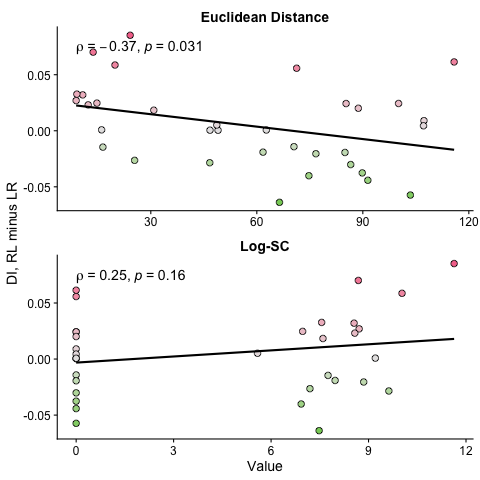

In [21]:
%%R -i structural_data

structural_data %>% 
    filter(Description %in% c("Euclidean Distance", "Log-SC")) %>%
    ggplot(aes(x=Value, y=Mean_RL_minus_LR_DI, fill=Mean_RL_minus_LR_DI)) +
    geom_point(color='black', shape=21, size=2.7) +
    scale_fill_gradient2(high="#f47599", low="#5dc636", mid="gray90") +
    geom_smooth(method="lm", se=FALSE, color='black') +
    facet_wrap(. ~ Description, scales="free", ncol=1) +
    theme(legend.position="none") +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5) +
    xlab("Value") +
    ylab("DI, RL minus LR") +
    theme(strip.background = element_blank(),
          strip.text = element_text(face='bold', size=14))
# ggsave("../plots/left_right_asymmetry/Mean_DI_LR_asymmetry_vs_physical_distance.svg", width=2.7, height=5, dpi=300, units="in")

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: The following aesthetics were dropped during statistical transformation: fill.
ℹ This can happen when ggplot fails to infer the correct grouping structure in
  the data.
ℹ Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor? 



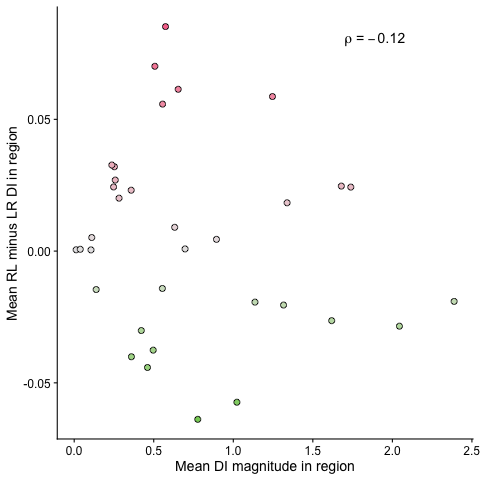

In [22]:
%%R -i region_DI_subtract_diffs

region_DI_subtract_diffs %>% 
    rowwise() %>%
    mutate(mean_DI_LR_magnitude = mean(c(DI_LR, DI_RL))) %>%
    group_by(base_region_to) %>%
    summarise(mean_DI_LR_magnitude = mean(mean_DI_LR_magnitude),
              mean_RL_minus_LR = mean(mean_RL_minus_LR)) %>%
    ggplot(aes(x=mean_DI_LR_magnitude, y=mean_RL_minus_LR, fill=mean_RL_minus_LR)) +
    scale_fill_gradient2(high="#f47599", low="#5dc636", mid="gray90") +
    geom_point(shape=21, size=2.5) +
    theme(legend.position="none") +
    ggpubr::stat_cor(method="spearman", cor.coef.name="rho", size=5, aes(label = ..r.label..), label.x = 1.7) +
    ylab("Mean RL minus LR DI in region") +
    xlab("Mean DI magnitude in region")
# ggsave("../plots/left_right_asymmetry/Mean_DI_LR_asymmetry_vs_magnitude.svg", width=2.7, height=2.5, dpi=300, units="in")

### Friedman test for variance in left-right asymmetry across all directed SPIs

In [ ]:
all_homotopic_res_directed_hemispheres = all_homotopic_res.query("Directionality == 'Directed'")

def compute_friedman_test_for_SPI(df, this_SPI):
    this_SPI_subset = df.query("SPI == @this_SPI")

    # Group by b
    this_SPI_subset_LR_diffs = (this_SPI_subset.groupby(['Subject', 'base_region_to'])
        .apply(lambda x: x.value[x.hemi_from=='left'].values - x.value[x.hemi_from=='right'].values)
        .reset_index()
        .rename(columns={0: 'RL_minus_LR'})
        # Flatten the list of arrays
        .explode('RL_minus_LR')
        )

    this_SPI_subset_LR_diffs_wide = this_SPI_subset_LR_diffs.pivot(index='Subject', columns='base_region_to', values='RL_minus_LR')

    # Fit a Friedman test with each column as input samples
    friedman_stat, friedman_p = friedmanchisquare(*this_SPI_subset_LR_diffs_wide.values.T)
    print(f"Friedman test for {this_SPI}: stat={friedman_stat}, P={friedman_p}")

    return pd.DataFrame({'SPI': [this_SPI], 'stat': [friedman_stat], 'p_value': [friedman_p]})

all_LR_friedman_res = pd.concat([compute_friedman_test_for_SPI(all_homotopic_res_directed_hemispheres, this_SPI) for this_SPI in all_homotopic_res_directed_hemispheres.SPI.unique()])
all_LR_friedman_res['p_BH'] = statsmodels.stats.multitest.multipletests(all_LR_friedman_res.p_value, method="Holm")[1]

In [34]:
%%R -i all_LR_friedman_res

all_LR_friedman_res %>% 
    filter(p_BH < 0.05) %>%
    mutate(SPI = fct_reorder(SPI, p_BH, .desc=TRUE)) %>%
    ggplot(data=., mapping=aes(x=SPI, y=-1*log10(p_BH), fill=-1*log10(p_BH))) +
    geom_bar(stat='identity') +
    # Add a black border to the di_gaussian bar
    scale_color_manual(values=c("black"), na.value=NA) +
    scale_y_continuous(expand=c(0,0)) +
    coord_flip() +
    theme(legend.position='none',
          axis.text.y=element_text(size=7)) 
ggsave("../plots/left_right_asymmetry/Friedman_test_results_all_SPIs.svg", width=5, height=8, dpi=300, units="in")

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


## Can volumetric differences at the individual subject level explain DI asymmetry?

In [46]:
# Read in brain region lookup table
brain_region_info = pd.read_csv("../Brain_Region_Info.csv")

# Load in regional volumes
regional_volumes = (pd.read_csv(f"{data_path}/raw_data/structural_MRI/HCP100_all_dk_volumes.csv")
                    .rename(columns={"Region": "Region_Index"})
                    .assign(Region_Index = lambda x: x.Region_Index.astype(int))
                    .merge(brain_region_info, on="Region_Index", how="left")
)

regional_volumes_asym = (regional_volumes.groupby(['Subject', 'Base_Region'])
        .apply(lambda x: (x.Volume[x.Hemisphere=='Left'].values - x.Volume[x.Hemisphere=='Right'].values) / np.mean(x.Volume))
        .reset_index()
        .rename(columns={0: 'volume_R_minus_L'})
        .explode('volume_R_minus_L')
        )

regional_volumes_asym

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_26583/4279012098.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regional_volumes_asym = (regional_volumes.groupby(['Subject', 'Base_Region'])


,Subject,Base_Region,volume_R_minus_L
0,100307,bankssts,NaN
1,100307,caudalanteriorcingulate,0.189911
2,100307,caudalmiddlefrontal,-0.032698
3,100307,cuneus,0.063621
4,100307,entorhinal,-0.052174
...,...,...,...
3395,899885,superiorparietal,0.072633
3396,899885,superiortemporal,-0.183575
3397,899885,supramarginal,-0.003923
3398,899885,temporalpole,-0.528302


In [50]:
%%R -i regional_volumes_asym

# What is the difference in DI by brain region?
regional_volumes_asym %>%
  mutate(volume_R_minus_L = as.numeric(volume_R_minus_L)) %>%
  group_by(Base_Region) %>%
  mutate(mean_volume_R_minus_L = mean(volume_R_minus_L, na.rm=TRUE),
         sd_volume_R_minus_L = sd(volume_R_minus_L, na.rm=TRUE)) %>%
  ungroup()  %>% 
  head()

# A tibble: 6 × 5
  Subject Base_Region volume_R_minus_L mean_volume_R_minus_L sd_volume_R_minus_L
    <int> <chr>                  <dbl>                 <dbl>               <dbl>
1  100307 bankssts             NA                  NaN                    NA    
2  100307 caudalante…           0.190                0.114                 0.266
3  100307 caudalmidd…          -0.0327               0.00430               0.222
4  100307 cuneus                0.0636               0.108                 0.252
5  100307 entorhinal           -0.0522              -0.0159                0.176
6  100307 frontalpole          -0.151                0.0584                0.194


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "volume_R_minus_L". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'numpy.float64'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


In [83]:
%%R -i regional_volumes_asym

# Plot in the brain
regional_volumes_asym %>%
  mutate(volume_R_minus_L = as.numeric(volume_R_minus_L)) %>%
  group_by(Base_Region) %>%
  summarise(mean_volume_R_minus_L = mean(volume_R_minus_L, na.rm=TRUE)) %>%
  distinct(Base_Region, mean_volume_R_minus_L) %>%
  mutate(label = glue("lh_{Base_Region}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = mean_volume_R_minus_L),
        position = "stacked", colour = "gray20", hemisphere="left") +
  theme_void() +
  scale_fill_gradient2(high="#f47599", low="#5dc636", mid="gray90", na.value = "white") +
  labs(fill = "Mean Volume asymmetry, (R-L)/mean(R+L)") +
  guides(fill=guide_colorbar(title.position='top')) +
  theme(plot.title = element_blank(),
        legend.position = "bottom",
        legend.key.width  = unit(3, "lines"),
        legend.key.height  = unit(0.7, "lines"),)
ggsave("../plots/left_right_asymmetry/Volume_L_R_asymmetry_in_brain.svg", width=4, height=3, dpi=300, units="in")

Joining with `by = join_by(label)`


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "volume_R_minus_L". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'float'> and <class 'numpy.float64'>). If happening with a pandas DataFrame the method infer_objects() will normalize data types before conversion.
  warnings.warn('Error while trying to convert '


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


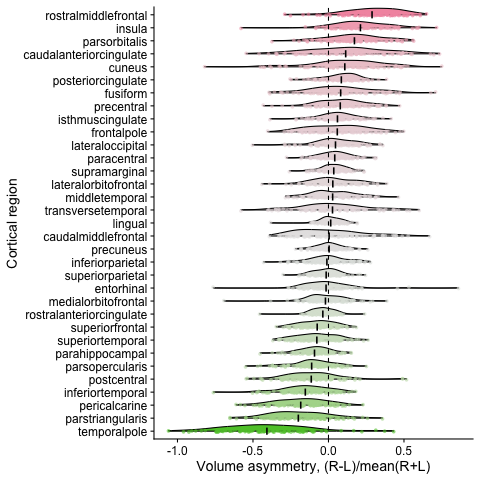

In [60]:
%%R -i regional_volumes_asym,region_order_DI_asym

# What is the difference in DI by brain region?
regional_volumes_asym <- regional_volumes_asym %>%
  mutate(volume_R_minus_L = as.numeric(volume_R_minus_L)) %>%
  group_by(Base_Region) %>%
  mutate(mean_volume_R_minus_L = mean(volume_R_minus_L, na.rm=TRUE),
         sd_volume_R_minus_L = sd(volume_R_minus_L, na.rm=TRUE)) %>%
  ungroup() %>%
  filter(!is.na(mean_volume_R_minus_L)) %>%
  mutate(Base_Region = fct_reorder(Base_Region, mean_volume_R_minus_L, .fun=mean))

regional_volumes_asym %>%
  ggplot(data=., mapping=aes(x=Base_Region, y=volume_R_minus_L, fill=mean_volume_R_minus_L)) +
  geom_violinhalf(scale="width", color="black", position = position_dodge(width = 2), width=1)  +
  geom_point(aes(color = mean_volume_R_minus_L), position = position_jitter(width = 0.075, height=0),
                          size = 1.75, alpha=0.6, stroke=0) +
  stat_summary(color="black", fun="mean", geom="crossbar", width=0.55, linewidth=0.3, 
          show.legend=FALSE, position = position_dodge(width=0))+
  scale_fill_gradient2(high="#f47599", low="#5dc636", mid="gray90") +
  scale_color_gradient2(high="#f47599", low="#5dc636", mid="gray90") +
  geom_hline(yintercept=0, linetype=2) +
  theme(legend.position="none")+
  coord_flip() +
  ylab("Volume asymmetry, (R-L)/mean(R+L)") +
  xlab("Cortical region")
# ggsave("../plots/left_right_asymmetry/volume_R_minus_L_violins.svg", width=6, height=8, dpi=300, units="in")

In [61]:
# Does gaussian DI R-L asymmetry correlate with volumetric asymmetry?
regional_volumes_asym

,Subject,Base_Region,volume_R_minus_L
0,100307,bankssts,NaN
1,100307,caudalanteriorcingulate,0.189911
2,100307,caudalmiddlefrontal,-0.032698
3,100307,cuneus,0.063621
4,100307,entorhinal,-0.052174
...,...,...,...
3395,899885,superiorparietal,0.072633
3396,899885,superiortemporal,-0.183575
3397,899885,supramarginal,-0.003923
3398,899885,temporalpole,-0.528302


In [76]:
# Correlation within regions
DI_vs_volume_asymm_corr_within_regions = (region_DI_subtract_diffs.rename(columns={"base_region_to": "Base_Region",
                                         "RL_minus_LR": "DI_RL_minus_LR"})
                         .merge(regional_volumes_asym, on=["Base_Region", 'Subject'], how="left")
                         .groupby("Base_Region")
                          .apply(lambda x: spearmanr(x['DI_RL_minus_LR'], x['volume_R_minus_L'])).apply(pd.Series)
)

mean_regional_DI_and_volume_asymm = (region_DI_subtract_diffs.rename(columns={"base_region_to": "Base_Region",
                                         "RL_minus_LR": "DI_RL_minus_LR"})
                         .merge(regional_volumes_asym, on=["Base_Region", 'Subject'], how="left")
                         .dropna()
                         .groupby("Base_Region")[['DI_RL_minus_LR', 'volume_R_minus_L']]
                         .mean()
                         .reset_index()
)
spearmanr(mean_regional_DI_and_volume_asymm.DI_RL_minus_LR, mean_regional_DI_and_volume_asymm.volume_R_minus_L)

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_26583/1650096100.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  DI_vs_volume_asymm_corr_within_regions = (region_DI_subtract_diffs.rename(columns={"base_region_to": "Base_Region",


SignificanceResult(statistic=np.float64(0.1002673796791444), pvalue=np.float64(0.5787679823624801))

In [94]:
%%R -i mean_regional_DI_and_volume_asymm

mean_regional_DI_and_volume_asymm %>% 
    mutate(volume_R_minus_L = as.numeric(volume_R_minus_L), 
           DI_RL_minus_LR = as.numeric(DI_RL_minus_LR)) %>%
    ggplot(data=., mapping=aes(x=volume_R_minus_L, y=DI_RL_minus_LR)) +
    geom_point() +
    geom_vline(xintercept=0, linetype='dashed') +
    geom_hline(yintercept=0, linetype='dashed') +
    ggpubr::stat_cor(method='spearman', cor.coef.name='rho', size=5)
ggsave("../plots/left_right_asymmetry/Volume_vs_DI_asymm_scatter.svg", width=3.25, height=3, dpi=300, units="in")

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "DI_RL_minus_LR". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning: Error while trying to convert the column "volume_R_minus_L". Fall back to string conversion. The error is: <class 'float'>
  warnings.warn('Error while trying to convert '
